In [1]:
import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
from clean_velocities import *
# tai from ... import *

# Database query

In [2]:
df = database_query("SELECT * FROM REITIT")
df

,ajokerta,node_id,timestamp,x,y,grid_id,kesto,color
0,2,1,2020-06-25 15:21:46,21,11,351,754.002,0
1,2,1,2020-06-25 15:21:47,21,11,351,754.002,1
2,2,1,2020-06-25 15:21:47,21,11,351,754.002,2
3,2,1,2020-06-25 15:21:47,21,11,351,754.002,3
4,2,1,2020-06-25 15:21:50,20,11,350,754.002,4
...,...,...,...,...,...,...,...,...
2542312,8038,31,2020-09-22 14:41:04,14,12,374,95.533,2542312
2542313,8038,31,2020-09-22 14:41:05,14,12,374,95.533,2542313
2542314,8038,31,2020-09-22 14:41:06,14,12,374,95.533,2542314
2542315,8038,31,2020-09-22 14:41:11,0,21,630,95.533,2542315


In [3]:
df = df.drop(['color'], axis=1)

In [4]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

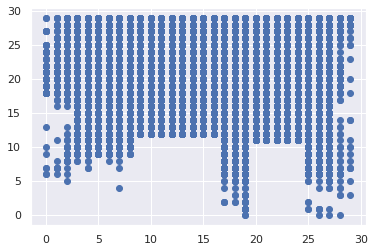

In [5]:
plt.scatter(df['x'],df['y'])

In [8]:
df_ajokerta = df[df['ajokerta'] < 20]

In [9]:
df_ajokerta

,ajokerta,node_id,timestamp,x,y,grid_id,kesto
0,2,1,2020-06-25 15:21:46,21,11,351,754.002
1,2,1,2020-06-25 15:21:47,21,11,351,754.002
2,2,1,2020-06-25 15:21:47,21,11,351,754.002
3,2,1,2020-06-25 15:21:47,21,11,351,754.002
4,2,1,2020-06-25 15:21:50,20,11,350,754.002
...,...,...,...,...,...,...,...
4993,19,1,2020-07-01 16:14:16,12,12,372,4865.998
4994,19,1,2020-07-01 16:14:27,12,12,372,4865.998
4995,19,1,2020-07-01 16:14:54,12,12,372,4865.998
4996,19,1,2020-07-01 16:14:55,12,12,372,4865.998


In [31]:
X= df_ajokerta[['x', 'y']]

In [23]:
def dbscan(X, eps, min_samples):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.figure(figsize=(20,10))
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Dark2', s = 50)
    plt.title("DBSCAN")


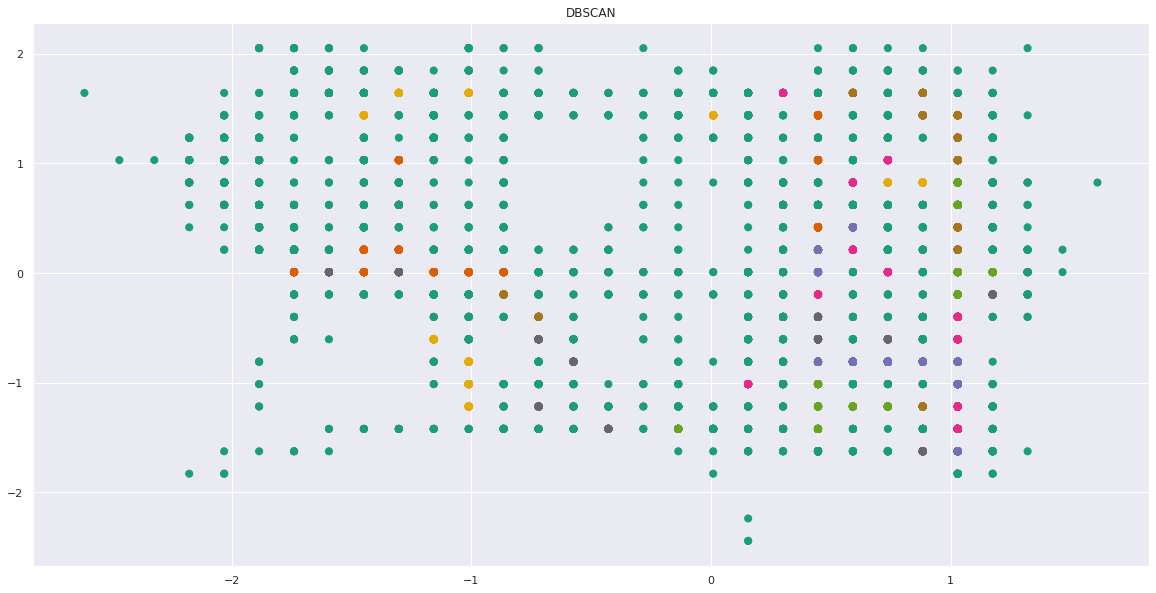

In [24]:
dbscan(X, 0.10, 20)

Estimated number of clusters: 8
Estimated number of noise points: 3647
Silhouette Coefficient: -0.264


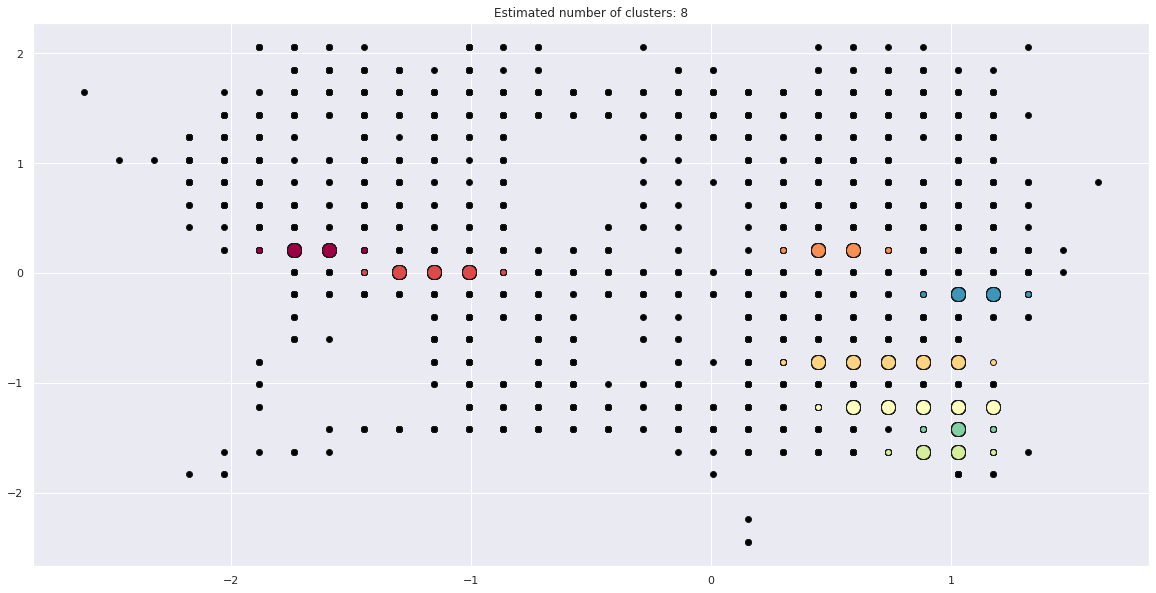

In [46]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################


X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=100).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)




print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()